In [1]:
import xarray as xr 
import wclass
import constants as cnst
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error as mae

In [2]:
dat = xr.open_dataarray(cnst.TESTDATA).squeeze()

In [3]:
dat

<xarray.DataArray 'SM' (latitude: 655, longitude: 1309)>
[857395 values with dtype=float32]
Coordinates:
    time                     object ...
    depth                    float32 ...
  * latitude                 (latitude) float32 3.5 3.541 3.581 ... 29.95 29.99
  * longitude                (longitude) float32 -18.0 -17.96 ... 34.93 34.97
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  object ...
Attributes:
    standard_name:    moisture_content_of_soil_layer
    units:            kg m-2
    um_stash_source:  m01s08i223
    um_runid:         ad251
    um_streamid:      ape
    um_version:       10.3
    grid_mapping:     latitude_longitude

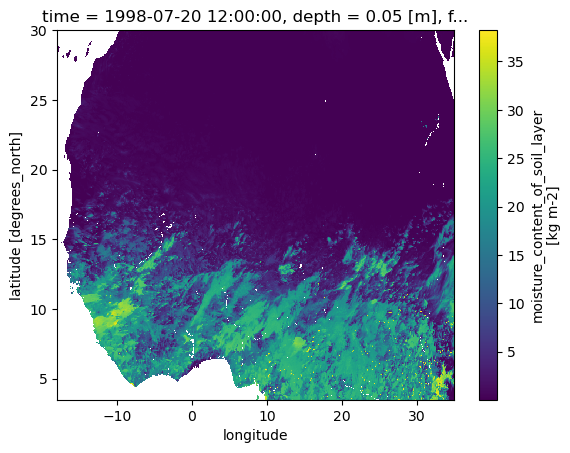

In [4]:
dat.plot()

In [26]:
# Let's zoom in
dat = dat.sel(latitude=slice(5,12), longitude=slice(0,24))

In [27]:
### Create a wavelet decomposition object first. In this example, we initialise the SM5k 5km setup. The setups can be defined in land_wavelet.constants
wObj = wclass.landwav('SM5k')

Initialised wavelet with scales:  [4.00000000e+00 4.75682846e+00 5.65685425e+00 6.72717132e+00
 8.00000000e+00 9.51365692e+00 1.13137085e+01 1.34543426e+01
 1.60000000e+01 1.90273138e+01 2.26274170e+01 2.69086853e+01
 3.20000000e+01 3.80546277e+01 4.52548340e+01 5.38173706e+01
 6.40000000e+01 7.61092554e+01 9.05096680e+01 1.07634741e+02
 1.28000000e+02 1.52218511e+02 1.81019336e+02 2.15269482e+02
 2.56000000e+02 3.04437021e+02 3.62038672e+02 4.30538965e+02
 5.12000000e+02 6.08874043e+02 7.24077344e+02 8.61077929e+02
 1.02400000e+03 1.21774809e+03 1.44815469e+03 1.72215586e+03
 2.04800000e+03 2.43549617e+03 2.89630938e+03 3.44431172e+03
 4.09600000e+03 4.87099234e+03]


In [28]:
### The wObj object saves certain infos on the initialised wavelet as well as the dataset the wavelet it supposed to be used on. IT IS IMPORTANT THAT THE INITIALISED WAVELET KNOWS ABOUT THE DATASET RESOLUTION

print('Initialised dataset resolution (info from utility function):', wObj.res)
print('Initialised wavelet scale start (info from utility function):',wObj.start)
print('Initialised scale numbers (info from utility function):',wObj.nb)
print('Initialised scales:', wObj.scales)

Initialised dataset resolution (info from utility function): 5
Initialised wavelet scale start (info from utility function): 4
Initialised scale numbers (info from utility function): 41
Initialised scales: [4.00000000e+00 4.75682846e+00 5.65685425e+00 6.72717132e+00
 8.00000000e+00 9.51365692e+00 1.13137085e+01 1.34543426e+01
 1.60000000e+01 1.90273138e+01 2.26274170e+01 2.69086853e+01
 3.20000000e+01 3.80546277e+01 4.52548340e+01 5.38173706e+01
 6.40000000e+01 7.61092554e+01 9.05096680e+01 1.07634741e+02
 1.28000000e+02 1.52218511e+02 1.81019336e+02 2.15269482e+02
 2.56000000e+02 3.04437021e+02 3.62038672e+02 4.30538965e+02
 5.12000000e+02 6.08874043e+02 7.24077344e+02 8.61077929e+02
 1.02400000e+03 1.21774809e+03 1.44815469e+03 1.72215586e+03
 2.04800000e+03 2.43549617e+03 2.89630938e+03 3.44431172e+03
 4.09600000e+03 4.87099234e+03]


In [29]:
### The next step prepares the SM image for the wavelet routine. NaNs are removed by filling in zeros that can be masked again after wavelet application.
wObj.read_img(dat.values, dat.longitude.values, dat.latitude.values)

Mean res is 0.04049997  I found that grid is not regular. If in doubt, please check.


Text(0.5, 1.0, 'SM anomaly without NaNs - note, there is ocean')

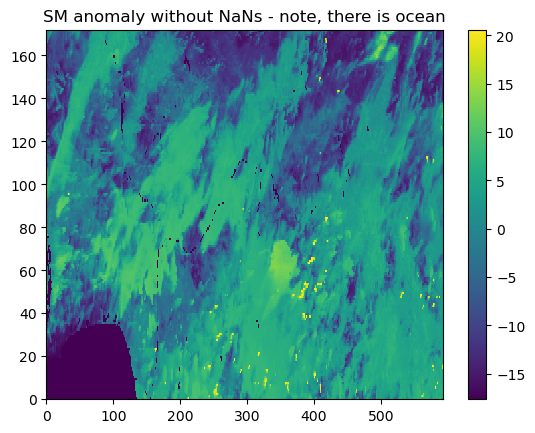

In [30]:
# The object saves the filtered image
plt.pcolormesh(wObj.image)  # the prepared (nans removed, anomaly) image
plt.colorbar()
plt.title('SM anomaly without NaNs - note, there is ocean')

In [31]:
# We now apply the wavelet scale decomposition to the image as defined in the wObj object. This step saves wavelet coefficients and powers to the object.
# The resulting powers could be used for diverse analyses.

coeffs, power, scales, period = wObj.applyWavelet(normed='none')

Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: none Please note: Choose none if value reconstruction is intended.


In [32]:
wObj.power.shape   # 0 dimension corresponds to number of decomposed scales

(42, 172, 593)

Text(0.5, 1.0, '4870.992343051146 km scale wavelet coefficients')

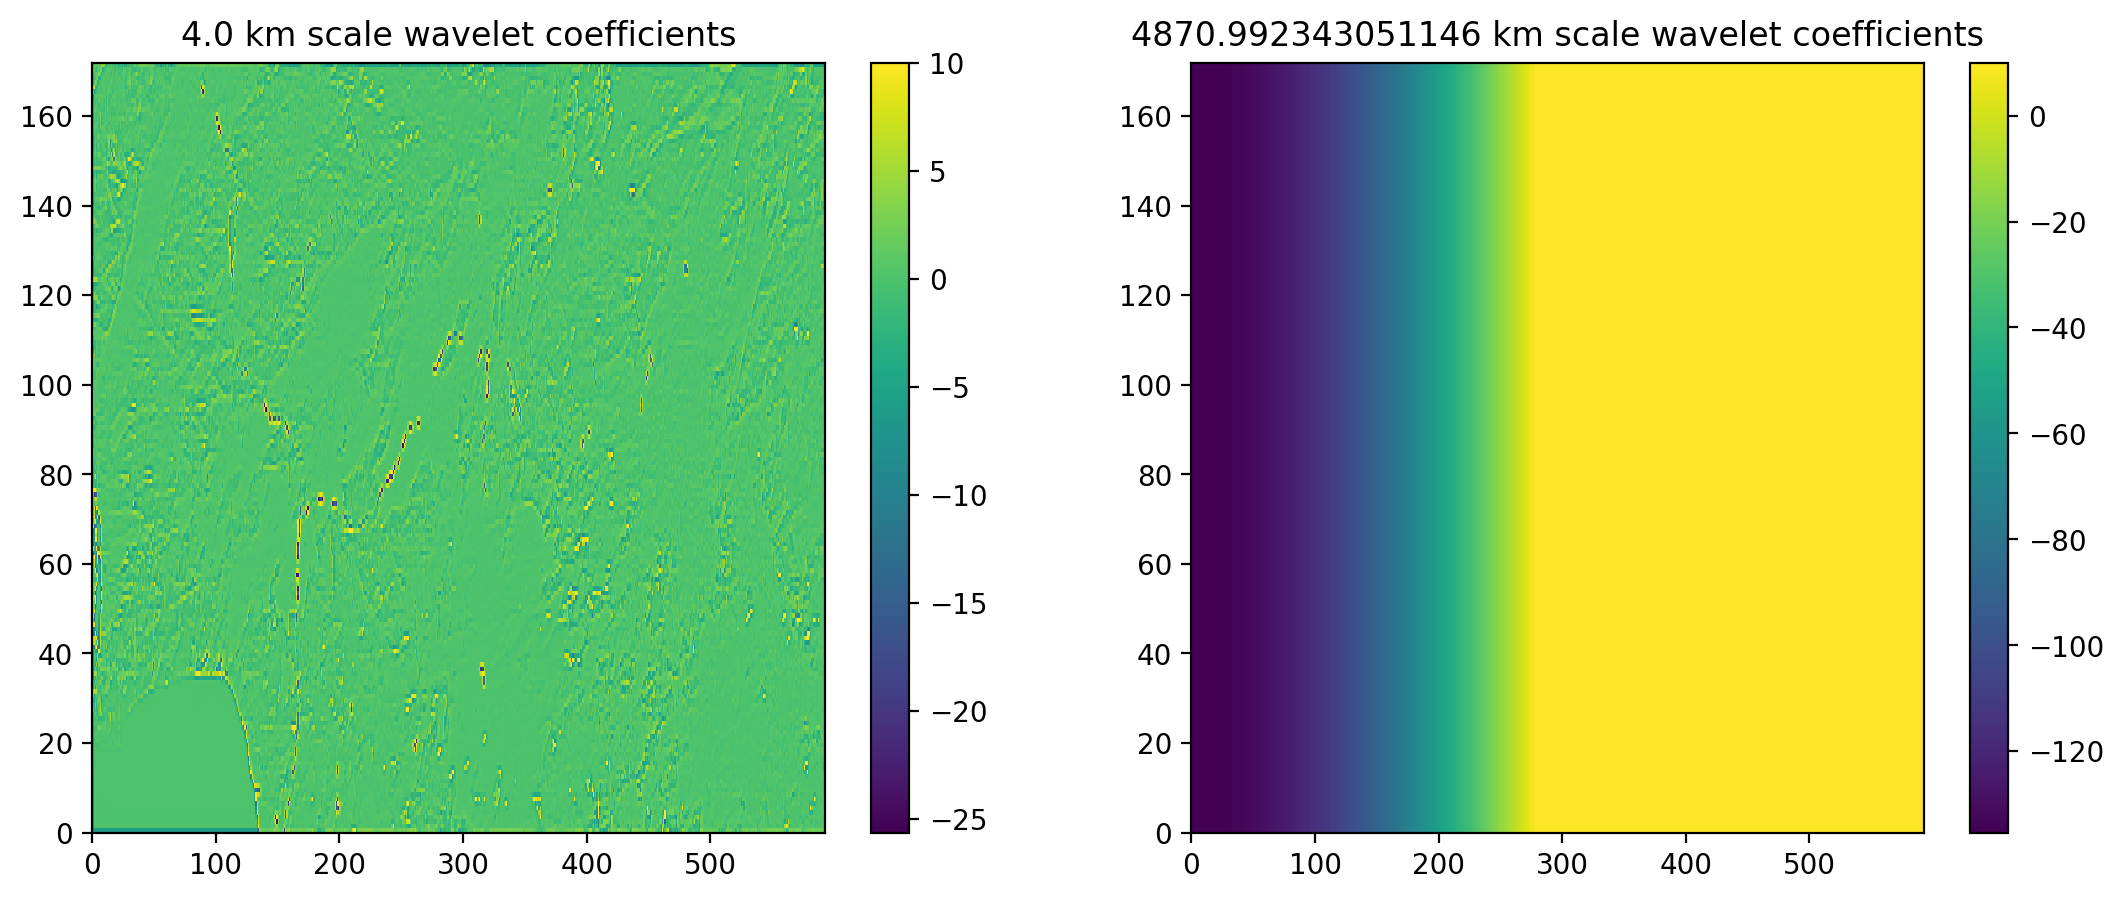

In [33]:
### This shows wavelet coefficient images of two chosen scales

f = plt.figure(figsize=(13,5), dpi=200)

ax = f.add_subplot(121)
scale_id = 0
plt.pcolormesh(wObj.coeffs[scale_id,:,:], vmax=10)
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale wavelet coefficients')


ax = f.add_subplot(122)
scale_id = -1

plt.pcolormesh(wObj.coeffs[scale_id,:,:], vmax=10)
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale wavelet coefficients')

Text(0.5, 1.0, 'Contours: 724.0 km power on SM')

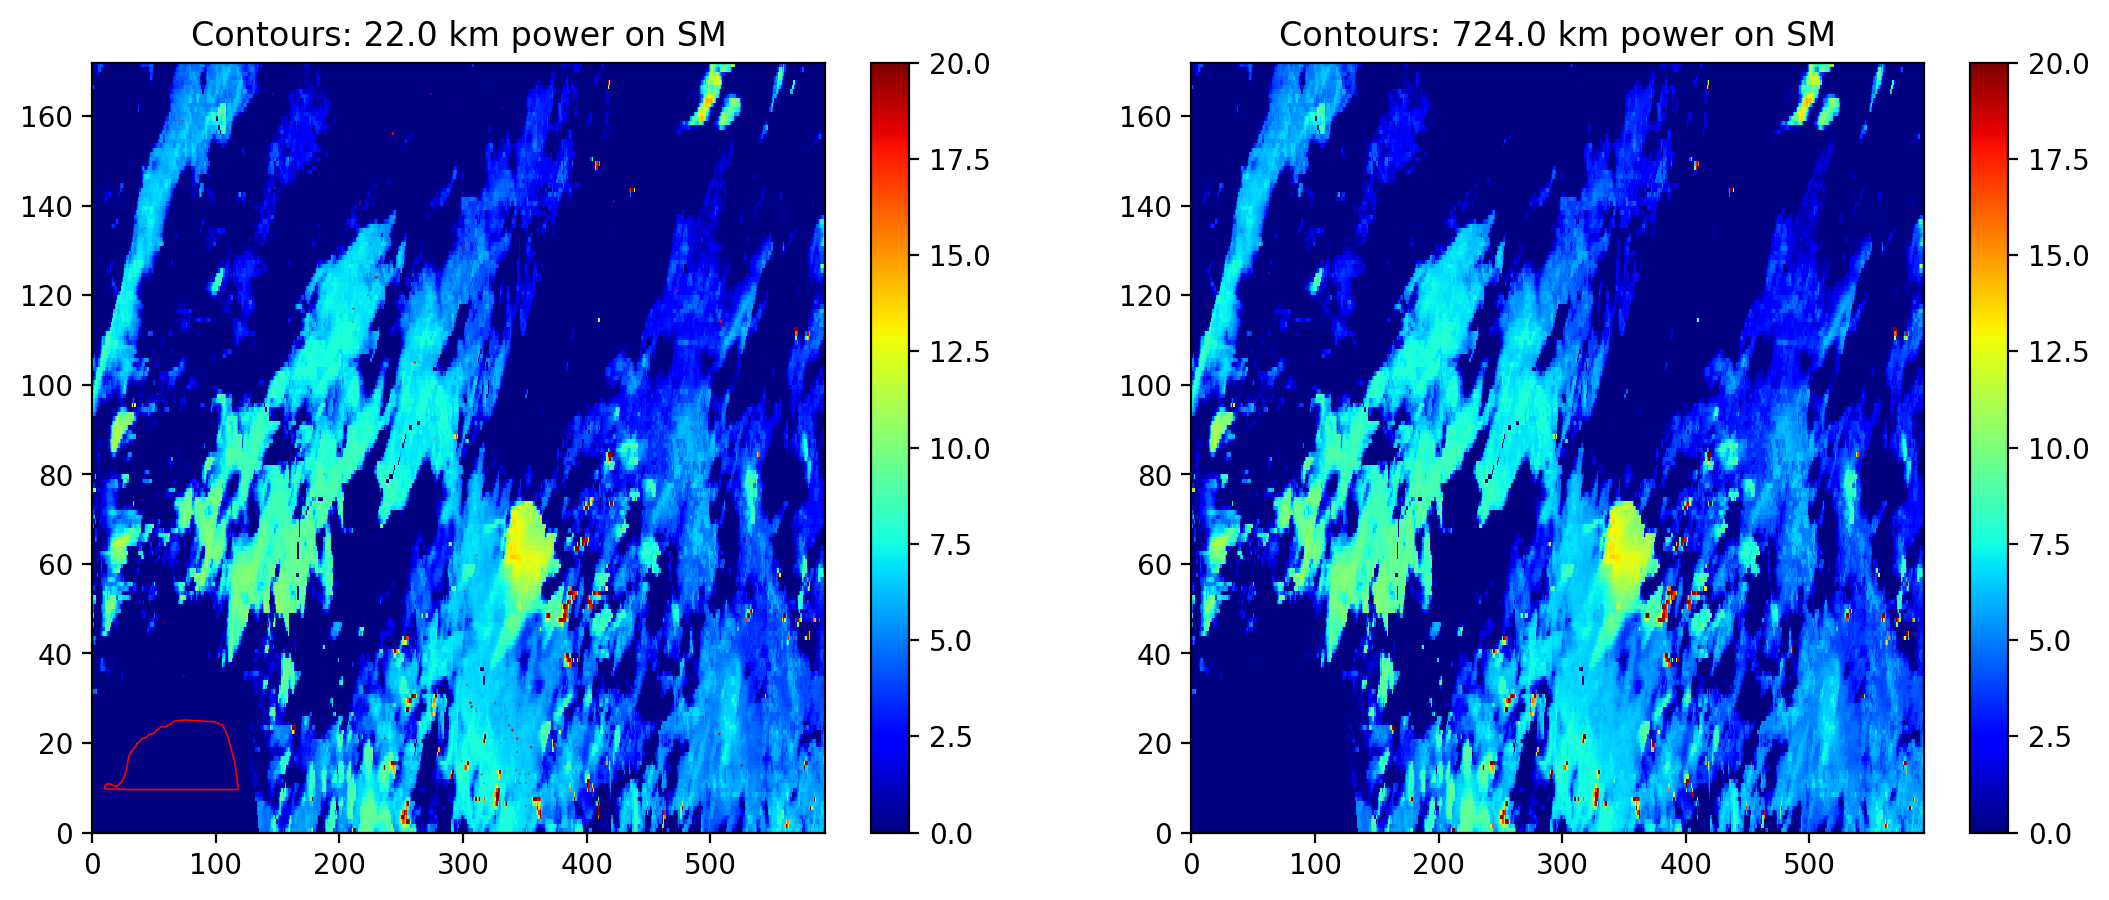

In [34]:
### Same powers as above but as contours plotted onto the SM image. 

f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(221)

plt.pcolormesh(wObj.image, vmax=20, vmin=0, cmap='jet')
plt.colorbar()
scale_id = 10
plt.contour(wObj.power[scale_id,:,:], levels=[-1,0.001,], colors=['r'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on SM')


ax = f.add_subplot(222)
scale_id = -12
plt.pcolormesh(wObj.image, vmax=20, vmin=0, cmap='jet')
plt.colorbar()
plt.contour(wObj.power[scale_id,:,:], levels=[-1,0.001], colors=['r'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on SM')

In [35]:
variableFull, scalesFull = wObj.applyInverseWavelet(per_scale=False)

In [36]:
# mask invalid areas again
original_anomaly = wObj.image.copy()
original_anomaly[wObj.invalid] = np.nan
variableFull[wObj.invalid] = np.nan

Text(0.5, 1.0, 'Reconstructed anomaly, inverse output')

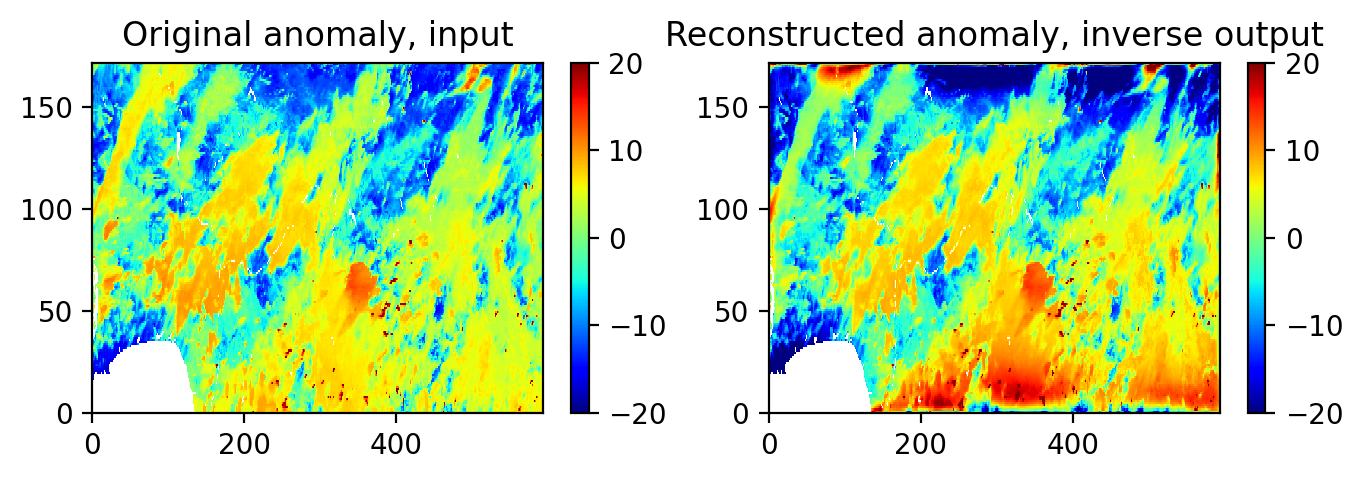

In [37]:
### Same powers as above but as contours plotted onto the SM image. NOTE THE EGDE EFFECTS FROM LARGE SCALES!

f = plt.figure(figsize=(8,5), dpi=200)

ax = f.add_subplot(221)

plt.pcolormesh(original_anomaly, cmap='jet', vmin=-20, vmax=20)
plt.colorbar()
plt.title('Original anomaly, input')


ax = f.add_subplot(222)
plt.pcolormesh(variableFull, cmap='jet', vmin=-20, vmax=20)
plt.colorbar()
plt.title('Reconstructed anomaly, inverse output')

Pearson correlation PearsonRResult(statistic=0.9981746157473642, pvalue=3.098851821223503e-237)
Mean abs error: 0.7804117634011934


Text(0.5, 1.0, 'NO EDGE EFFECT SLICE')

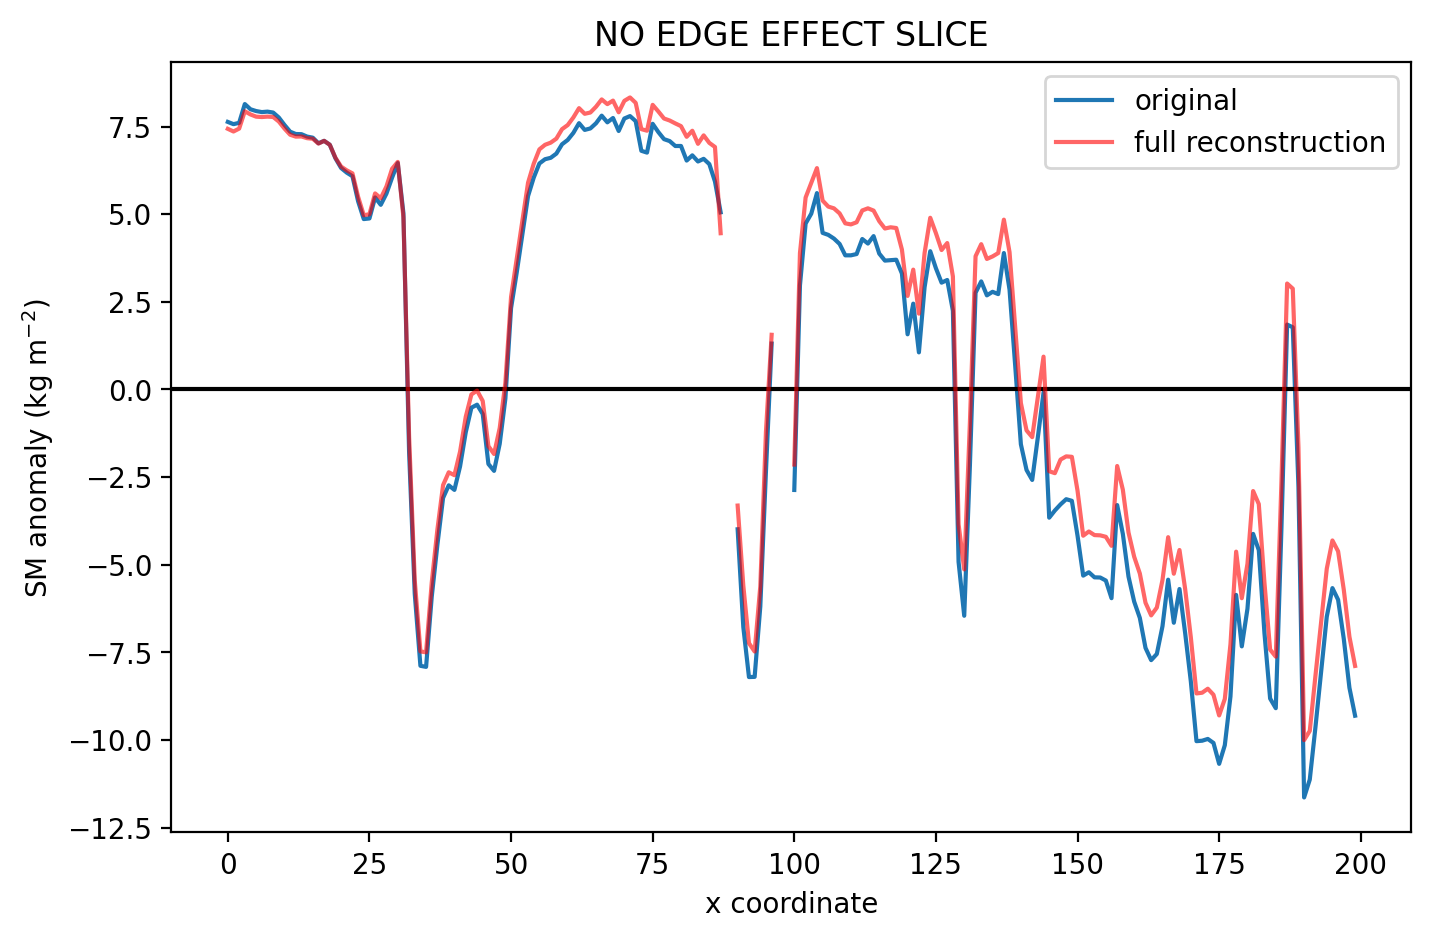

In [38]:
idx = 110  # x-id 110

f = plt.figure(figsize=(8,5), dpi=200)
ax = f.add_subplot(111)

orig = original_anomaly[idx,200:400]  # choose comparison slice
reconst = variableFull[idx,200:400]
valid = np.isfinite(orig)

plt.plot(orig, label='original')
ax.axhline(0, color='k')
plt.plot(reconst,'red', alpha=0.6, label='full reconstruction')
ax.set_ylabel('SM anomaly (kg m$^{-2}$)')
ax.set_xlabel('x coordinate')

print('Pearson correlation', stats.pearsonr(orig[valid], reconst[valid]))
print('Mean abs error:', mae(orig[valid], reconst[valid]))
plt.legend()
plt.title('NO EDGE EFFECT SLICE')

Pearson correlation PearsonRResult(statistic=0.9582348964033144, pvalue=8.933e-321)
Mean abs error: 1.3400595425360469


Text(0.5, 1.0, 'WITH ZONAL EDGE EFFECT SLICE')

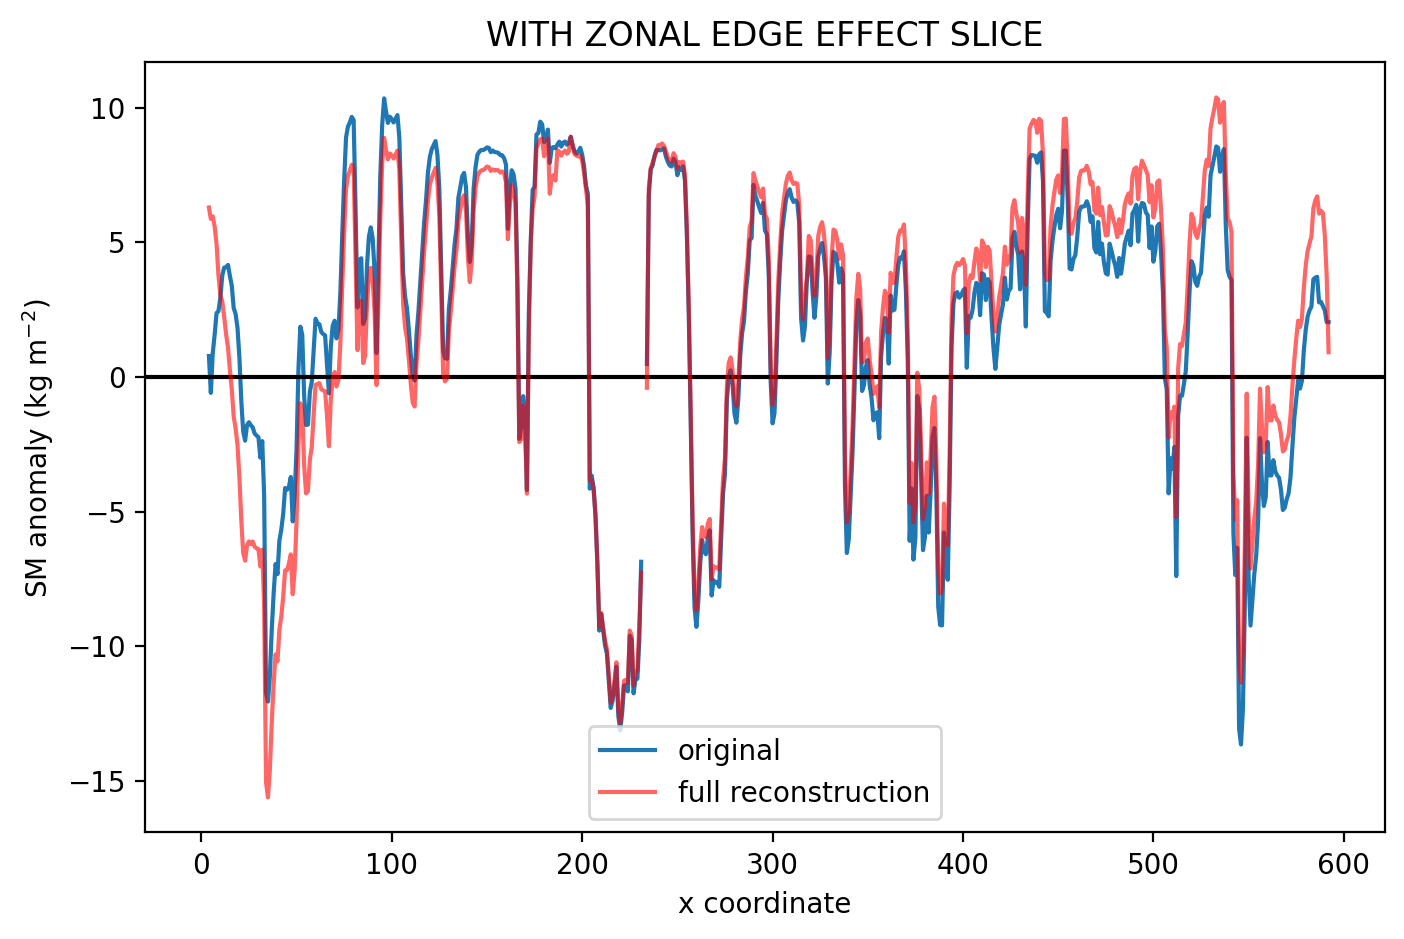

In [39]:
idx = 75  # x-id 110

f = plt.figure(figsize=(8,5), dpi=200)
ax = f.add_subplot(111)

orig = original_anomaly[idx,:] # starting in edge effect area
reconst = variableFull[idx,:]
valid = np.isfinite(orig)

plt.plot(orig, label='original')
ax.axhline(0, color='k')
plt.plot(reconst,'red', alpha=0.6, label='full reconstruction')
ax.set_ylabel('SM anomaly (kg m$^{-2}$)')
ax.set_xlabel('x coordinate')


print('Pearson correlation', stats.pearsonr(orig[valid], reconst[valid]))
print('Mean abs error:', mae(orig[valid], reconst[valid]))
plt.legend()
plt.title('WITH ZONAL EDGE EFFECT SLICE')

Pearson correlation PearsonRResult(statistic=0.909280437034064, pvalue=1.2745557124250224e-66)
Mean abs error: 2.6403044090454513


Text(0.5, 1.0, 'MERIDIONAL EDGE EFFECT')

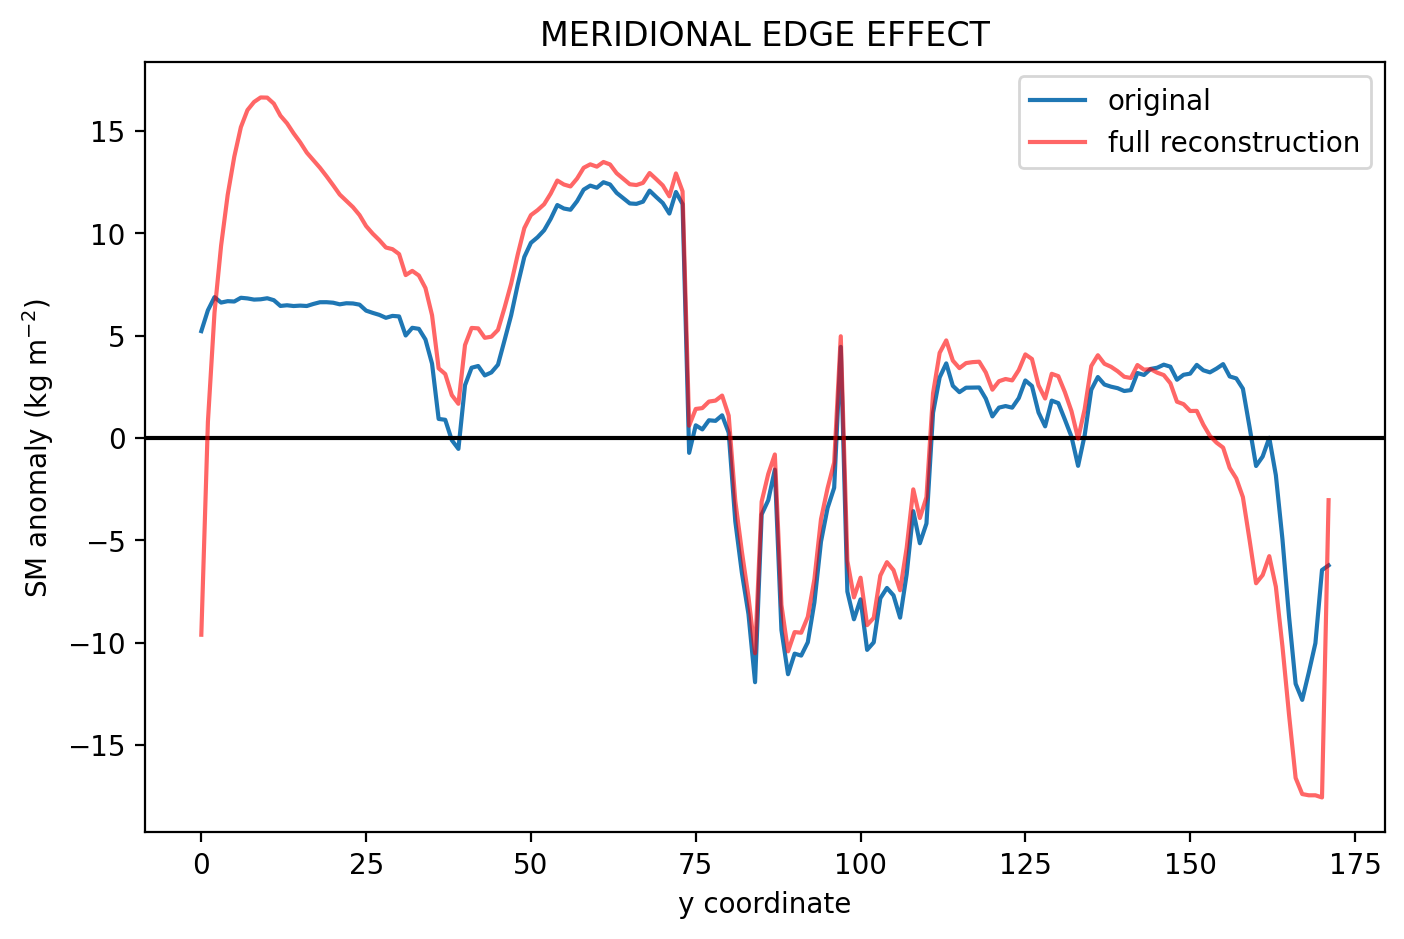

In [40]:
idx = 350  # x-id 110

f = plt.figure(figsize=(8,5), dpi=200)
ax = f.add_subplot(111)

orig = original_anomaly[:,idx] # starting in edge effect area
reconst = variableFull[:, idx]
valid = np.isfinite(orig)

plt.plot(orig, label='original')
ax.axhline(0, color='k')
plt.plot(reconst,'red', alpha=0.6, label='full reconstruction')
ax.set_ylabel('SM anomaly (kg m$^{-2}$)')
ax.set_xlabel('y coordinate')


print('Pearson correlation', stats.pearsonr(orig[valid], reconst[valid]))
print('Mean abs error:', mae(orig[valid], reconst[valid]))
plt.legend()
plt.title('MERIDIONAL EDGE EFFECT')

In [41]:
## Get individual scales, set "per_scale=True" for same wavelet object

variableIndi, scalesIndi = wObj.applyInverseWavelet(per_scale=True)

In [42]:
# For comparison: Illustration of no sensitivity to number of scales FOR INDIVIDUAL SCALES
# Full workflow with fewer scales for new wavelet object.

wObj2 = wclass.landwav('SM5k_sensiTest')
wObj2.read_img(dat.values, dat.longitude.values, dat.latitude.values) # same input data
coeffs2, power2, scales2, period2 = wObj2.applyWavelet(normed='none')
variableFull2, scalesFull2 = wObj2.applyInverseWavelet(per_scale=False)
variableIndi2, scalesIndi2 = wObj2.applyInverseWavelet(per_scale=True)

Initialised wavelet with scales:  [  5.           5.74349177   6.59753955   7.57858283   8.70550563
  10.          11.48698355  13.19507911  15.15716567  17.41101127
  20.          22.9739671   26.39015822  30.31433133  34.82202253
  40.          45.9479342   52.78031643  60.62866266  69.64404506
  80.          91.8958684  105.56063286 121.25732532 139.28809013
 160.         183.7917368  211.12126572 242.51465064 278.57618025
 320.         367.5834736  422.24253145 485.02930128 557.15236051
 640.         735.1669472 ]
Mean res is 0.04049997  I found that grid is not regular. If in doubt, please check.
Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: none Please note: Choose none if value reconstruction is intended.


In [43]:
variableIndi2.shape

(37, 172, 593)

Pearson correlation PearsonRResult(statistic=0.909280437034064, pvalue=1.2745557124250224e-66)
Mean abs error: 2.6403044090454513


Text(0.5, 1.0, 'Note sensitivity of full reconstruction to full scale range')

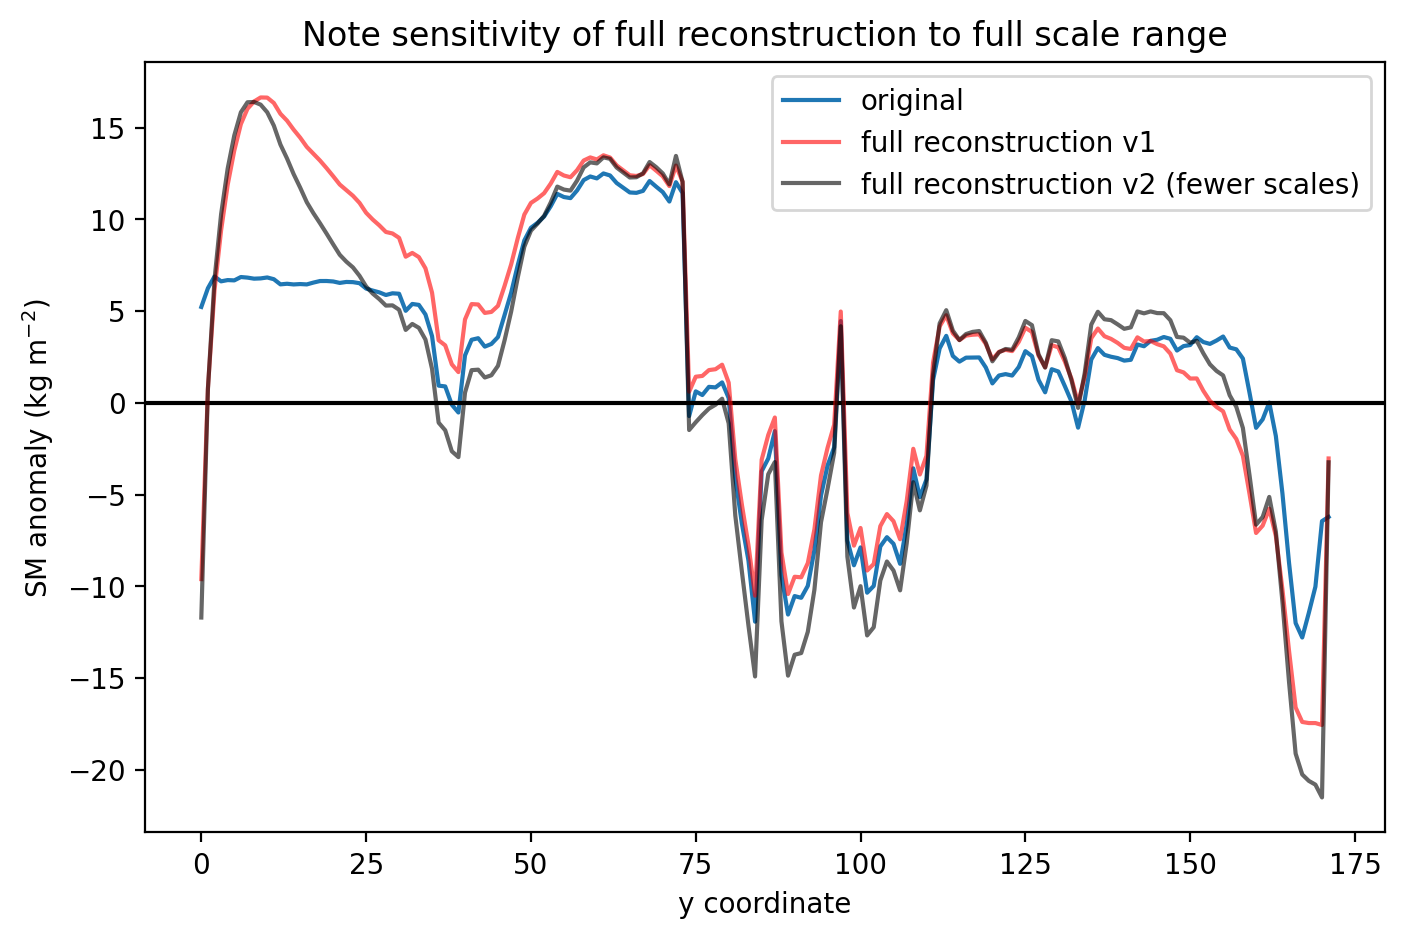

In [44]:
idx = 350  # x-id 110

f = plt.figure(figsize=(8,5), dpi=200)
ax = f.add_subplot(111)

orig = original_anomaly[:,idx] # starting in edge effect area
reconstv1 = variableFull[:, idx]
reconstv2 = variableFull2[:, idx]
valid = np.isfinite(orig)

plt.plot(orig, label='original')
ax.axhline(0, color='k')
plt.plot(reconstv1,'red', alpha=0.6, label='full reconstruction v1')
plt.plot(reconstv2,'k', alpha=0.6, label='full reconstruction v2 (fewer scales)')
ax.set_ylabel('SM anomaly (kg m$^{-2}$)')
ax.set_xlabel('y coordinate')


print('Pearson correlation', stats.pearsonr(orig[valid], reconst[valid]))
print('Mean abs error:', mae(orig[valid], reconst[valid]))
plt.legend()
plt.title('Note sensitivity of full reconstruction to full scale range')

Text(0.5, 1.0, 'Individual scales are not affected by total scale number (different y-axis value range)')

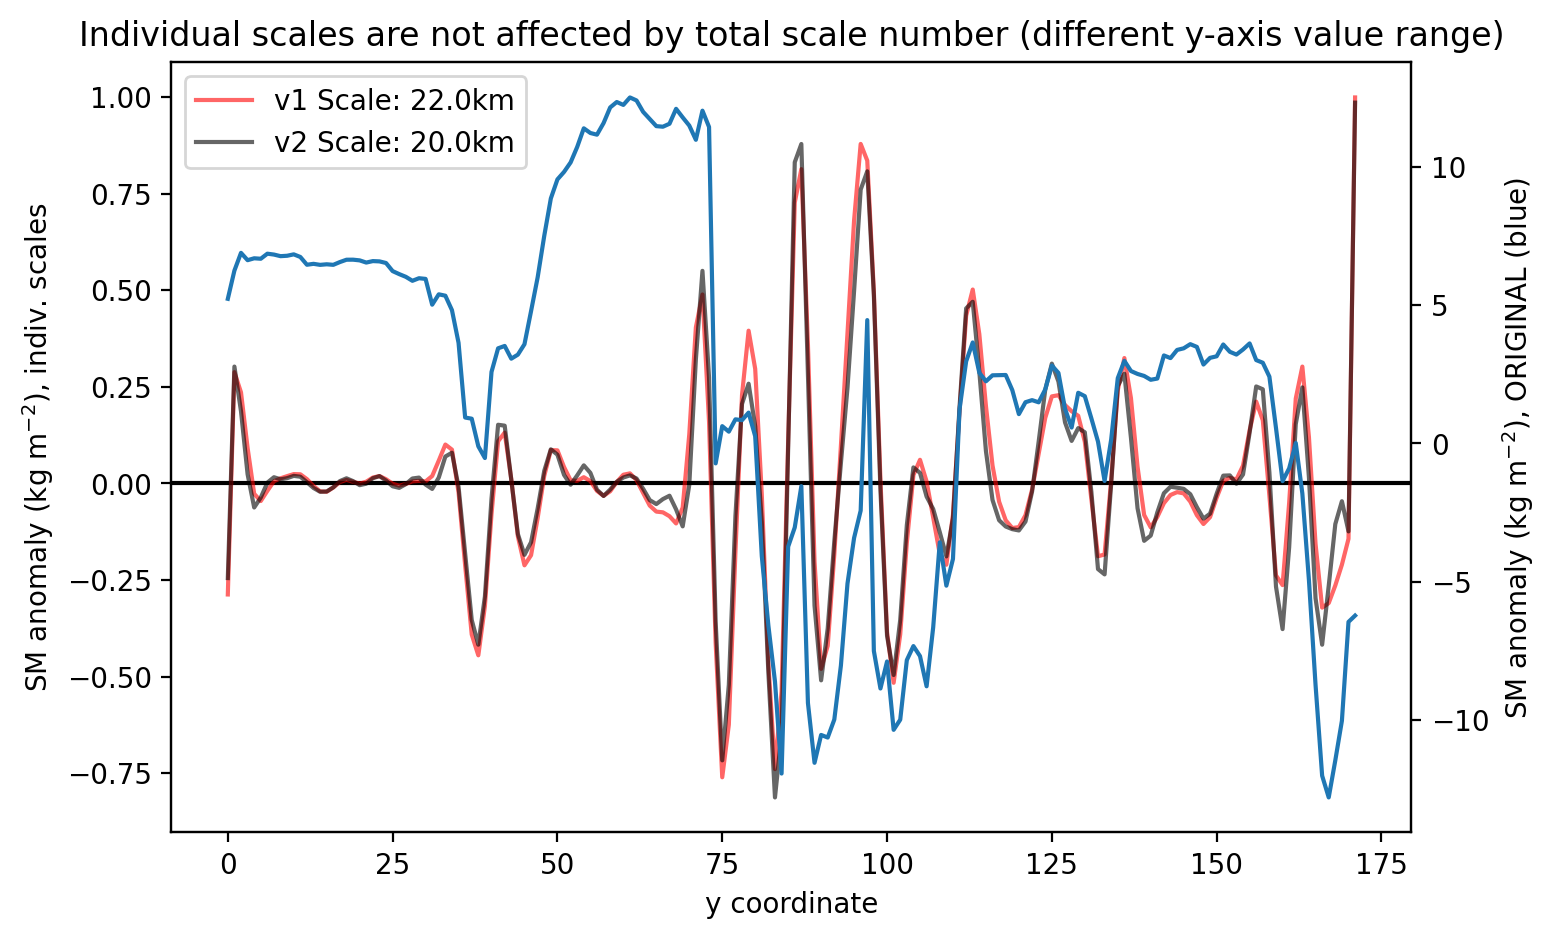

In [45]:
idx = 350  # x-id 110

idscale = 10
f = plt.figure(figsize=(8,5), dpi=200)

orig = original_anomaly[:,idx] # starting in edge effect area
reconstv1 = variableIndi[idscale, :, idx]
reconstv2 = variableIndi2[idscale, :, idx]

iscalev2 = scalesIndi2[idscale]
iscalev1 = scalesIndi[idscale]

ax = f.add_subplot(111)
ax.axhline(0, color='k')
ax.plot(reconstv1,'red', alpha=0.6, label='v1 Scale: '+str(np.floor(iscalev1))+'km')
ax.plot(reconstv2,'k', alpha=0.6, label='v2 Scale: '+str(np.floor(iscalev2))+'km')
ax.set_ylabel('SM anomaly (kg m$^{-2}$), indiv. scales')
ax.set_xlabel('y coordinate')
ax.legend()

ax1 = ax.twinx()
ax1.plot(orig, label='original')
ax1.set_ylabel('SM anomaly (kg m$^{-2}$), ORIGINAL (blue)')


plt.title('Individual scales are not affected by total scale number (different y-axis value range)')

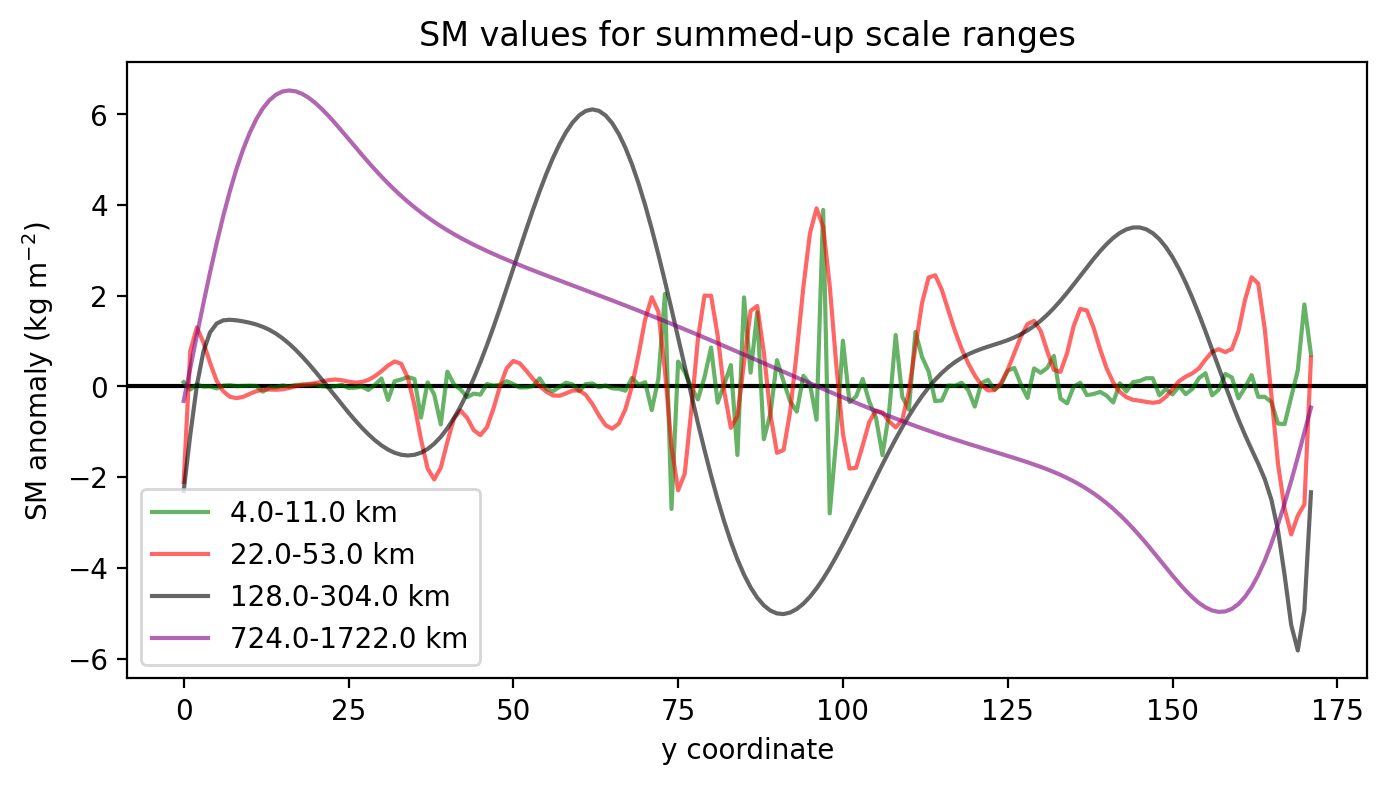

In [46]:
idx = 350

cs = ['green','red', 'k', 'purple','blue']

f = plt.figure(figsize=(8,4), dpi=200)
ax = f.add_subplot(111)
ax.axhline(0, color='k')
for six, si in enumerate([1,10,20,30]):
    plt.plot(variableIndi[si:si+5,:,idx].sum(axis=0), alpha=0.6, color=cs[six], label = str(np.floor(scalesIndi[si]))+'-'+str(np.floor(scalesIndi[si+5]))+' km')
    
ax.set_ylabel('SM anomaly (kg m$^{-2}$)')
ax.set_xlabel('y coordinate')    
plt.title('SM values for summed-up scale ranges')
plt.legend(fontsize=10)